In [1]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore Warnings
warnings.filterwarnings("ignore")

C:\Users\narah\anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_dir = "./datasets/chest_xray/"
categories = ["NORMAL","PNEUMONIA"]
filepaths = []
labels = []

In [3]:
for fold in os.listdir(data_dir):
    foldpath = os.path.join(data_dir, fold)
    for file in os.listdir(foldpath):
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [4]:
df.head()

,filepaths,labels
0,./datasets/chest_xray/NORMAL\.DS_Store,NORMAL
1,./datasets/chest_xray/NORMAL\IM-0001-0001.jpeg,NORMAL
2,./datasets/chest_xray/NORMAL\IM-0003-0001.jpeg,NORMAL
3,./datasets/chest_xray/NORMAL\IM-0005-0001.jpeg,NORMAL
4,./datasets/chest_xray/NORMAL\IM-0006-0001.jpeg,NORMAL


In [5]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=123)

In [6]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

def optimal_batch_size(df):
    ts_length = len(df)
    return max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

test_batch_size = optimal_batch_size(test_df)

In [7]:

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function=scalar)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 4684 validated image filenames belonging to 2 classes.
Found 703 validated image filenames belonging to 2 classes.
Found 469 validated image filenames belonging to 2 classes.


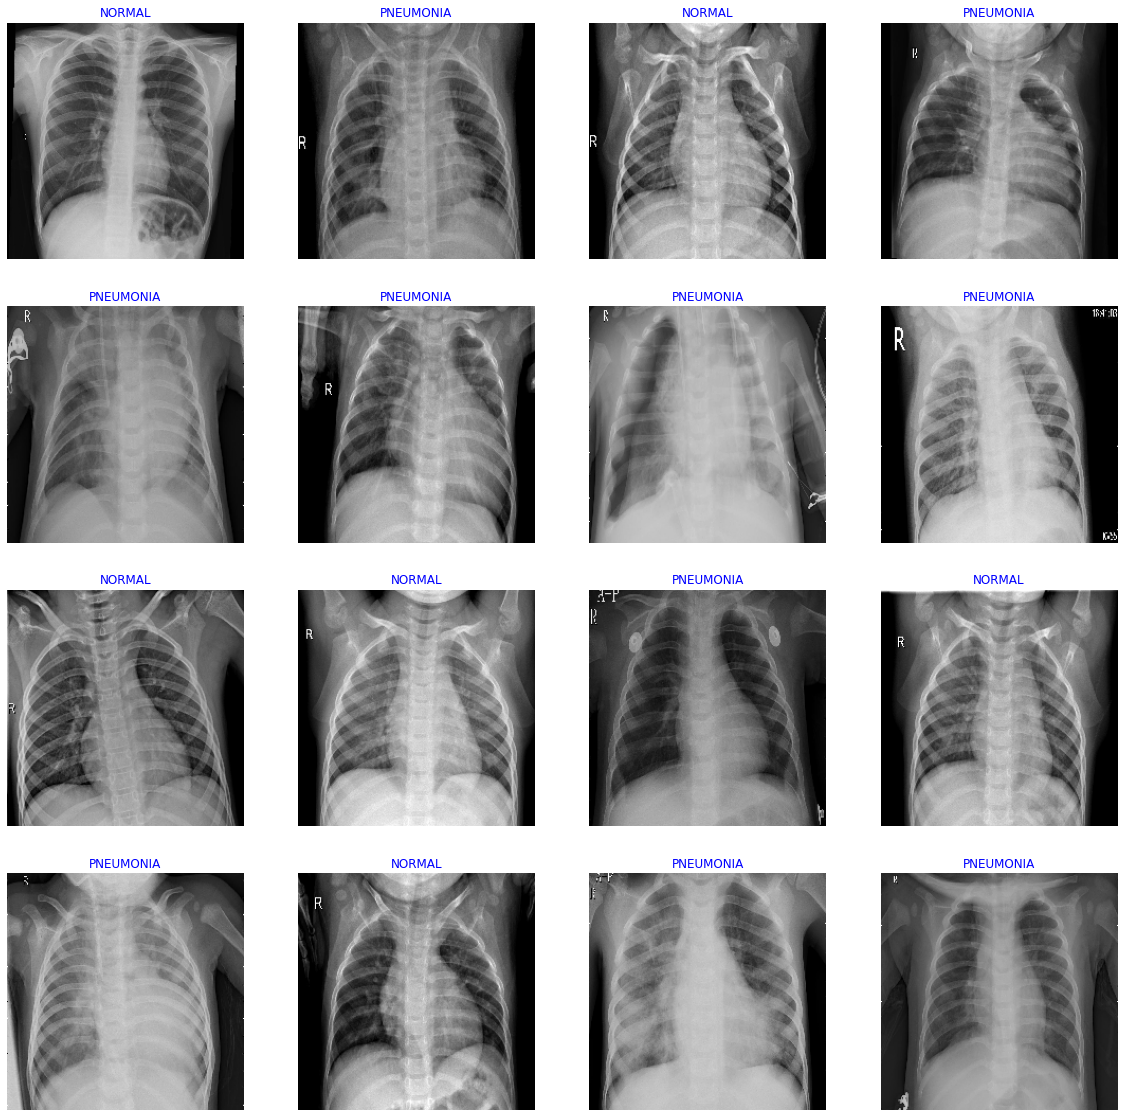

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()


In [9]:
img_shape = (224, 224, 3)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Flatten(),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
if tf.config.list_physical_devices('GPU'):
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)

In [11]:
batch_size = 32
epochs = 24

history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/24
293/293 [==============================] - 533s 2s/step - loss: 6.9467 - accuracy: 0.9084 - val_loss: 3.5331 - val_accuracy: 0.9545
Epoch 2/24
293/293 [==============================] - 484s 2s/step - loss: 2.6846 - accuracy: 0.9424 - val_loss: 2.1170 - val_accuracy: 0.9132
Epoch 3/24
293/293 [==============================] - 454s 2s/step - loss: 1.6545 - accuracy: 0.9451 - val_loss: 1.3644 - val_accuracy: 0.9488
Epoch 4/24
293/293 [==============================] - 455s 2s/step - loss: 1.2012 - accuracy: 0.9471 - val_loss: 1.1187 - val_accuracy: 0.9417
Epoch 5/24
293/293 [==============================] - 494s 2s/step - loss: 1.0630 - accuracy: 0.9449 - val_loss: 1.5294 - val_accuracy: 0.9047
Epoch 6/24
293/293 [==============================] - 474s 2s/step - loss: 1.0159 - accuracy: 0.9532 - val_loss: 0.9606 - val_accuracy: 0.9587
Epoch 7/24
293/293 [==============================] - 473s 2s/step - loss: 0.8078 - accuracy: 0.9582 - val_loss: 0.8345 - val_accuracy: 0.9374

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0]*100)
print("Train Accuracy: ", train_score[1]*100)
print('-' * 20)
print("Validation Loss: ", valid_score[0]*100)
print("Validation Accuracy: ", valid_score[1]*100)
print('-' * 20)
print("Test Loss: ", test_score[0]*100)
print("Test Accuracy: ", test_score[1]*100)

7/7 [==============================] - 11s 2s/step - loss: 0.5157 - accuracy: 0.9424
Train Loss:  27.872055768966675
Train Accuracy:  100.0
--------------------
Validation Loss:  54.404956102371216
Validation Accuracy:  95.53571343421936
--------------------
Test Loss:  51.56984329223633
Test Accuracy:  94.24306750297546


In [13]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

7/7 [==============================] - 10s 1s/step


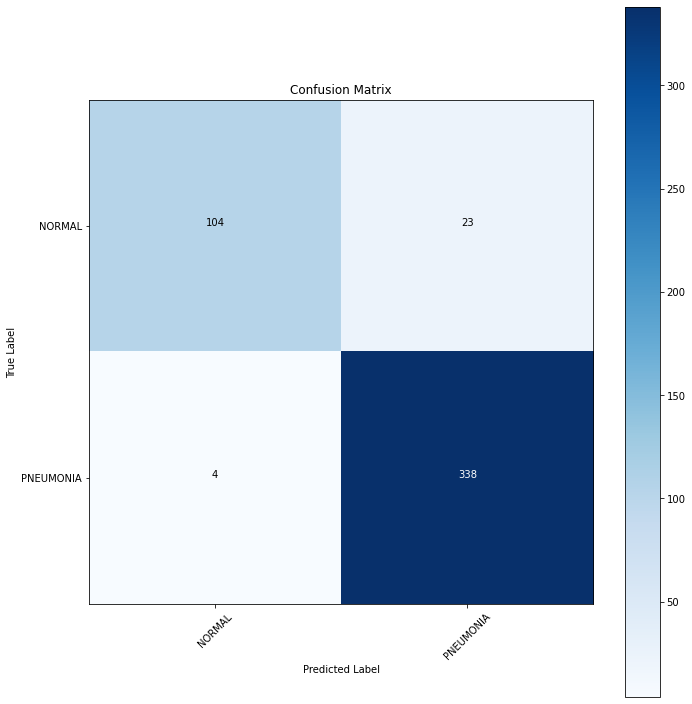

In [14]:
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(test_gen.class_indices))
plt.xticks(tick_marks, test_gen.class_indices, rotation=45)
plt.yticks(tick_marks, test_gen.class_indices)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
print(classification_report(test_gen.classes, y_pred, target_names=test_gen.class_indices))

              precision    recall  f1-score   support

      NORMAL       0.96      0.82      0.89       127
   PNEUMONIA       0.94      0.99      0.96       342

    accuracy                           0.94       469
   macro avg       0.95      0.90      0.92       469
weighted avg       0.94      0.94      0.94       469



In [ ]:
import pickle
import gzip
with gzip.open("./models/pneumonia.pkl",'wb') as f:
    pickle.dump(model, f,protocol = pickle.HIGHEST_PROTOCOL)